LOADING DATA

Dataset shape: (2000, 14)

First few rows:
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0  6253     L53432    L                300.8                    310.3   
1  4685     M19544    M                303.6                    311.8   
2  1732     M16591    M                298.3                    307.9   
3  4743     L51922    L                303.3                    311.3   
4  4522     L51701    L                302.4                    310.4   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1538         36.1              198                0    0   
1                    1421         44.8              101                1    0   
2                    1485         42.0              117                0    0   
3                    1592         33.7               14                0    0   
4                    1865         23.9              129                0    0   

   HDF  PWF  OSF 

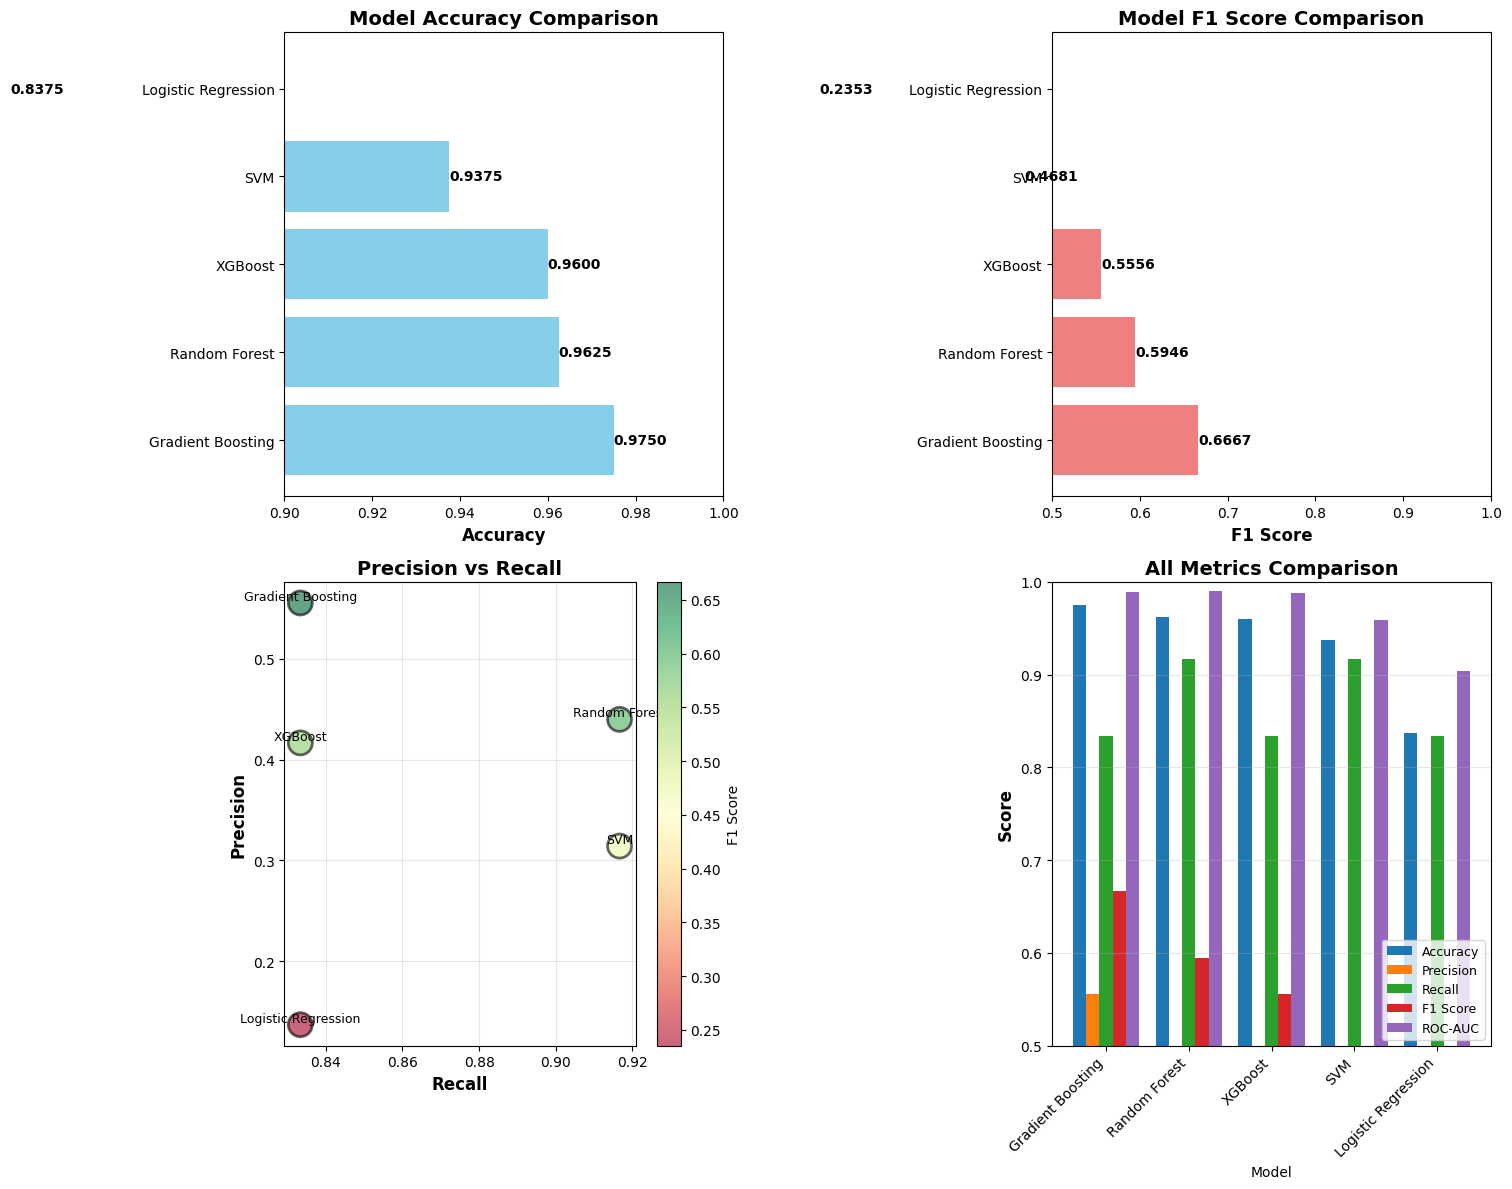

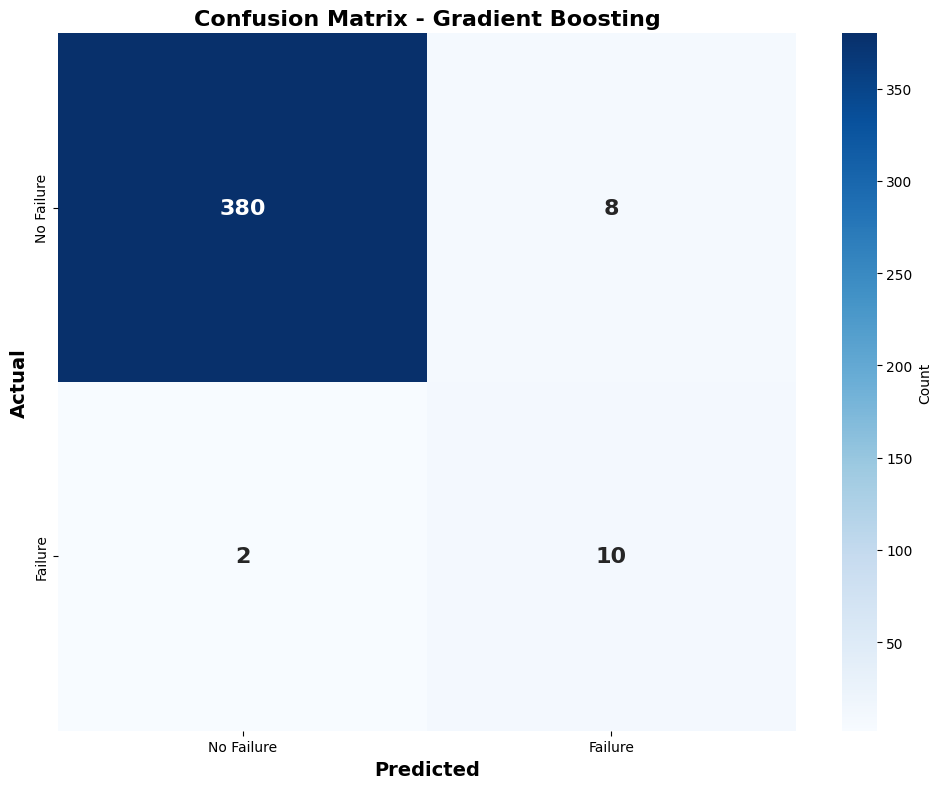

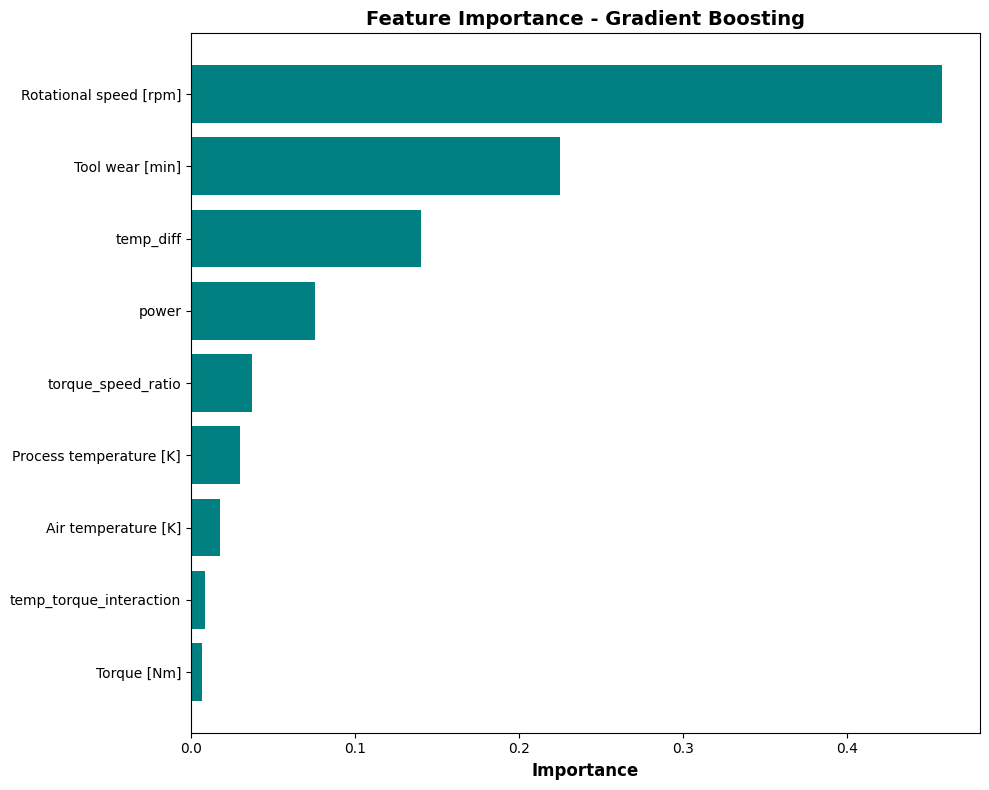

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                             accuracy_score, roc_auc_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# =============================================
# 1. LOAD AND EXPLORE DATA
# =============================================
print("="*70)
print("LOADING DATA")
print("="*70)

df = pd.read_csv('ai4i2020.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nMachine Failure distribution:")
print(df['Machine failure'].value_counts())
print(f"Failure rate: {df['Machine failure'].mean():.4f}")

# =============================================
# 2. FEATURE ENGINEERING
# =============================================
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Select features for training
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Create additional engineered features
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] / 1000
df['torque_speed_ratio'] = df['Torque [Nm]'] / (df['Rotational speed [rpm]'] + 1)
df['temp_torque_interaction'] = df['Process temperature [K]'] * df['Torque [Nm]']

# Add engineered features
feature_cols.extend(['temp_diff', 'power', 'torque_speed_ratio', 'temp_torque_interaction'])

print(f"\nFeatures used: {feature_cols}")
print(f"Total features: {len(feature_cols)}")

# =============================================
# 3. PREPARE DATA
# =============================================
print("\n" + "="*70)
print("PREPARING DATA")
print("="*70)

X = df[feature_cols]
y_machine_failure = df['Machine failure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_machine_failure, test_size=0.2, random_state=42, stratify=y_machine_failure
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Failure ratio in training: {y_train.sum() / len(y_train):.4f}")
print(f"Failure ratio in test: {y_test.sum() / len(y_test):.4f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
print("\nApplying SMOTE for class balancing...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Training set: {X_train_resampled.shape[0]} samples")
print(f"After SMOTE - Class distribution: {np.bincount(y_train_resampled)}")

# =============================================
# 4. TRAIN MULTIPLE MODELS
# =============================================
print("\n" + "="*70)
print("TRAINING MULTIPLE MODELS FOR COMPARISON")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ),
    'SVM': SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        random_state=42
    )
}

# Store results
results = []
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    # Train model
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model
    
    # Predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
    
    # Cross-validation F1 score
    cv_f1 = cross_val_score(model, X_train_resampled, y_train_resampled, 
                            cv=5, scoring='f1', n_jobs=-1).mean()
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'CV F1 Score': cv_f1
    })
    
    print(f"\nResults:")
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  Precision:    {precision:.4f}")
    print(f"  Recall:       {recall:.4f}")
    print(f"  F1 Score:     {f1:.4f}")
    print(f"  ROC-AUC:      {roc_auc:.4f}")
    print(f"  CV F1 Score:  {cv_f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# =============================================
# 5. MODEL COMPARISON
# =============================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n" + results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1 Score']
best_accuracy = results_df.iloc[0]['Accuracy']

print("\n" + "="*70)
print(f" BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   F1 Score: {best_f1:.4f}")
print("="*70)

# =============================================
# 6. VISUALIZE COMPARISON
# =============================================
print("\n" + "="*70)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*70)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([0.9, 1.0])
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# Plot 2: F1 Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(results_df['Model'], results_df['F1 Score'], color='lightcoral')
ax2.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim([0.5, 1.0])
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# Plot 3: Precision vs Recall
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['Recall'], results_df['Precision'], 
                     s=300, alpha=0.6, c=results_df['F1 Score'], 
                     cmap='RdYlGn', edgecolors='black', linewidth=2)
for i, txt in enumerate(results_df['Model']):
    ax3.annotate(txt, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]),
                fontsize=9, ha='center', va='bottom')
ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax3.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='F1 Score')

# Plot 4: All Metrics Comparison
ax4 = axes[1, 1]
metrics_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']].set_index('Model')
metrics_df.plot(kind='bar', ax=ax4, width=0.8)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_ylim([0.5, 1.0])
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Comparison plot saved as 'model_comparison.png'")

# =============================================
# 7. CONFUSION MATRIX FOR BEST MODEL
# =============================================
print("\n" + "="*70)
print(f"CONFUSION MATRIX FOR BEST MODEL: {best_model_name}")
print("="*70)

best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Best model confusion matrix saved as 'best_model_confusion_matrix.png'")

# =============================================
# 8. FEATURE IMPORTANCE (FOR TREE-BASED MODELS)
# =============================================
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print("\n" + "="*70)
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("="*70)
    
    if best_model_name == 'XGBoost':
        importances = best_model.feature_importances_
    else:
        importances = best_model.feature_importances_
    
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n" + feature_importance.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\nFeature importance plot saved as 'feature_importance.png'")

# =============================================
# 9. TRAIN FAILURE TYPE MODELS WITH BEST ALGORITHM
# =============================================
print("\n" + "="*70)
print(f"TRAINING FAILURE TYPE MODELS USING {best_model_name}")
print("="*70)

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_models = {}
failure_results = []

# Only train on samples where machine failure occurred
failure_indices = df[df['Machine failure'] == 1].index
X_failures = df.loc[failure_indices, feature_cols]
print(f"\nTotal failure samples: {len(X_failures)}")

for failure_type in failure_types:
    print(f"\n{'='*70}")
    print(f"Training {best_model_name} for {failure_type}")
    print(f"{'='*70}")
    
    y_failure = df.loc[failure_indices, failure_type]
    
    print(f"Samples: {len(y_failure)}, Positives: {y_failure.sum()}")
    
    if y_failure.sum() < 5:
        print(f"  Not enough positive samples for {failure_type}. Skipping...")
        continue
    
    # Split data
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(
        X_failures, y_failure, test_size=0.2, random_state=42, stratify=y_failure
    )
    
    # Scale
    X_f_train_scaled = scaler.transform(X_f_train)
    X_f_test_scaled = scaler.transform(X_f_test)
    
    # Apply SMOTE if needed
    if y_f_train.sum() > 1 and len(y_f_train) - y_f_train.sum() > 1:
        k_neighbors = min(3, y_f_train.sum()-1)
        smote_f = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_f_train_resampled, y_f_train_resampled = smote_f.fit_resample(
            X_f_train_scaled, y_f_train
        )
    else:
        X_f_train_resampled, y_f_train_resampled = X_f_train_scaled, y_f_train
    
    # Create model instance based on best model
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=200, max_depth=10, 
                                      class_weight='balanced', random_state=42, n_jobs=-1)
    elif best_model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                            scale_pos_weight=len(y_f_train[y_f_train==0])/max(len(y_f_train[y_f_train==1]), 1),
                            random_state=42, eval_metric='logloss')
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                          max_depth=6, random_state=42)
    else:
        model = RandomForestClassifier(n_estimators=200, max_depth=10,
                                      class_weight='balanced', random_state=42, n_jobs=-1)
    
    # Train
    model.fit(X_f_train_resampled, y_f_train_resampled)
    
    # Predict
    y_f_pred = model.predict(X_f_test_scaled)
    
    # Metrics
    acc = accuracy_score(y_f_test, y_f_pred)
    f1 = f1_score(y_f_test, y_f_pred, zero_division=0)
    precision = precision_score(y_f_test, y_f_pred, zero_division=0)
    recall = recall_score(y_f_test, y_f_pred, zero_division=0)
    
    print(f"\nResults for {failure_type}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    failure_models[failure_type] = model
    failure_results.append({
        'Failure Type': failure_type,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Display failure type results
if failure_results:
    print("\n" + "="*70)
    print("FAILURE TYPE CLASSIFICATION SUMMARY")
    print("="*70)
    failure_results_df = pd.DataFrame(failure_results)
    print("\n" + failure_results_df.to_string(index=False))

# =============================================
# 10. SAVE MODELS
# =============================================
print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

import pickle

# Save best model and scaler
with open('best_machine_failure_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('failure_type_models.pkl', 'wb') as f:
    pickle.dump(failure_models, f)

with open('model_comparison_results.pkl', 'wb') as f:
    pickle.dump(results_df, f)

print(f"\n Best model saved: {best_model_name}")
print("Files saved:")
print("   - best_machine_failure_model.pkl")
print("   - scaler.pkl")
print("   - failure_type_models.pkl")
print("   - model_comparison_results.pkl")
print("   - model_comparison.png")
print("   - best_model_confusion_matrix.png")
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print("   - feature_importance.png")

print("\n" + "="*70)
print(" TRAINING COMPLETE! ")
print("="*70)
print(f"\n Best Model: {best_model_name}")
print(f" Accuracy: {best_accuracy:.4f}")
print(f" F1 Score: {best_f1:.4f}")
print("="*70)